# LN-229 cell viability

This notebook was used to calculate and plot Supplementary Figure 4.
Jasmina Kubitschek, 2024

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pylab
import statsmodels.api as sm
import seaborn as sns
import scipy
from scipy.optimize import curve_fit
import sys
print(sys.version)

3.11.6 (main, Jun  7 2024, 07:09:59) [GCC 13.2.0]


In [2]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['mathtext.default'] = "regular"

mpl.rcParams['font.size'] = 12

In [3]:
# folder paths
path = '/nfs/nas12.ethz.ch/fs1201/green_groups_let_public/Euler/O6meG_revision/Plotting/'
data_path = path + 'Source_data/'
graph_path = path + 'Graphs/Supplementary_figures/'

In [4]:
viability = pd.read_csv(data_path + 'LN229_TMZ_viability_df.csv', sep=';') 
viability

viability    TMZ_conc cell_type incubation
0     0.965896   untreated       Neo        24h
1     1.000000     1% DMSO       Neo        24h
2     1.019983       50 mM       Neo        24h
3     1.043288      100 mM       Neo        24h
4     1.052781      250 mM       Neo        24h
..         ...         ...       ...        ...
211   0.749658      250 mM      MGMT       144h
212   0.851762      500 mM      MGMT       144h
213   0.614033      750 mM      MGMT       144h
214   0.645317     1000 mM      MGMT       144h
215   0.210115  3x 1000 mM      MGMT       144h

[216 rows x 4 columns]

In [5]:
# clean up
values_to_replace = ['1% DMSO', 
                     ' mM', '3x 1000',
                     'Neo', 'MGMT',
                     '24h','72h', '144h']
replacement_values = ['0',
                      '', '3000',
                      'LN-229 WT', 'LN-229 +MGMT',
                      '24', '72', '144']
replacing_names_dict = dict(zip(values_to_replace, replacement_values))

viability = viability.replace(replacing_names_dict, regex=True)
viability

viability   TMZ_conc     cell_type incubation
0     0.965896  untreated     LN-229 WT         24
1     1.000000          0     LN-229 WT         24
2     1.019983         50     LN-229 WT         24
3     1.043288        100     LN-229 WT         24
4     1.052781        250     LN-229 WT         24
..         ...        ...           ...        ...
211   0.749658        250  LN-229 +MGMT        144
212   0.851762        500  LN-229 +MGMT        144
213   0.614033        750  LN-229 +MGMT        144
214   0.645317       1000  LN-229 +MGMT        144
215   0.210115       3000  LN-229 +MGMT        144

[216 rows x 4 columns]

LOWESS performs weighted local linear fits: https://www.statsmodels.org/dev/examples/notebooks/generated/lowess.html

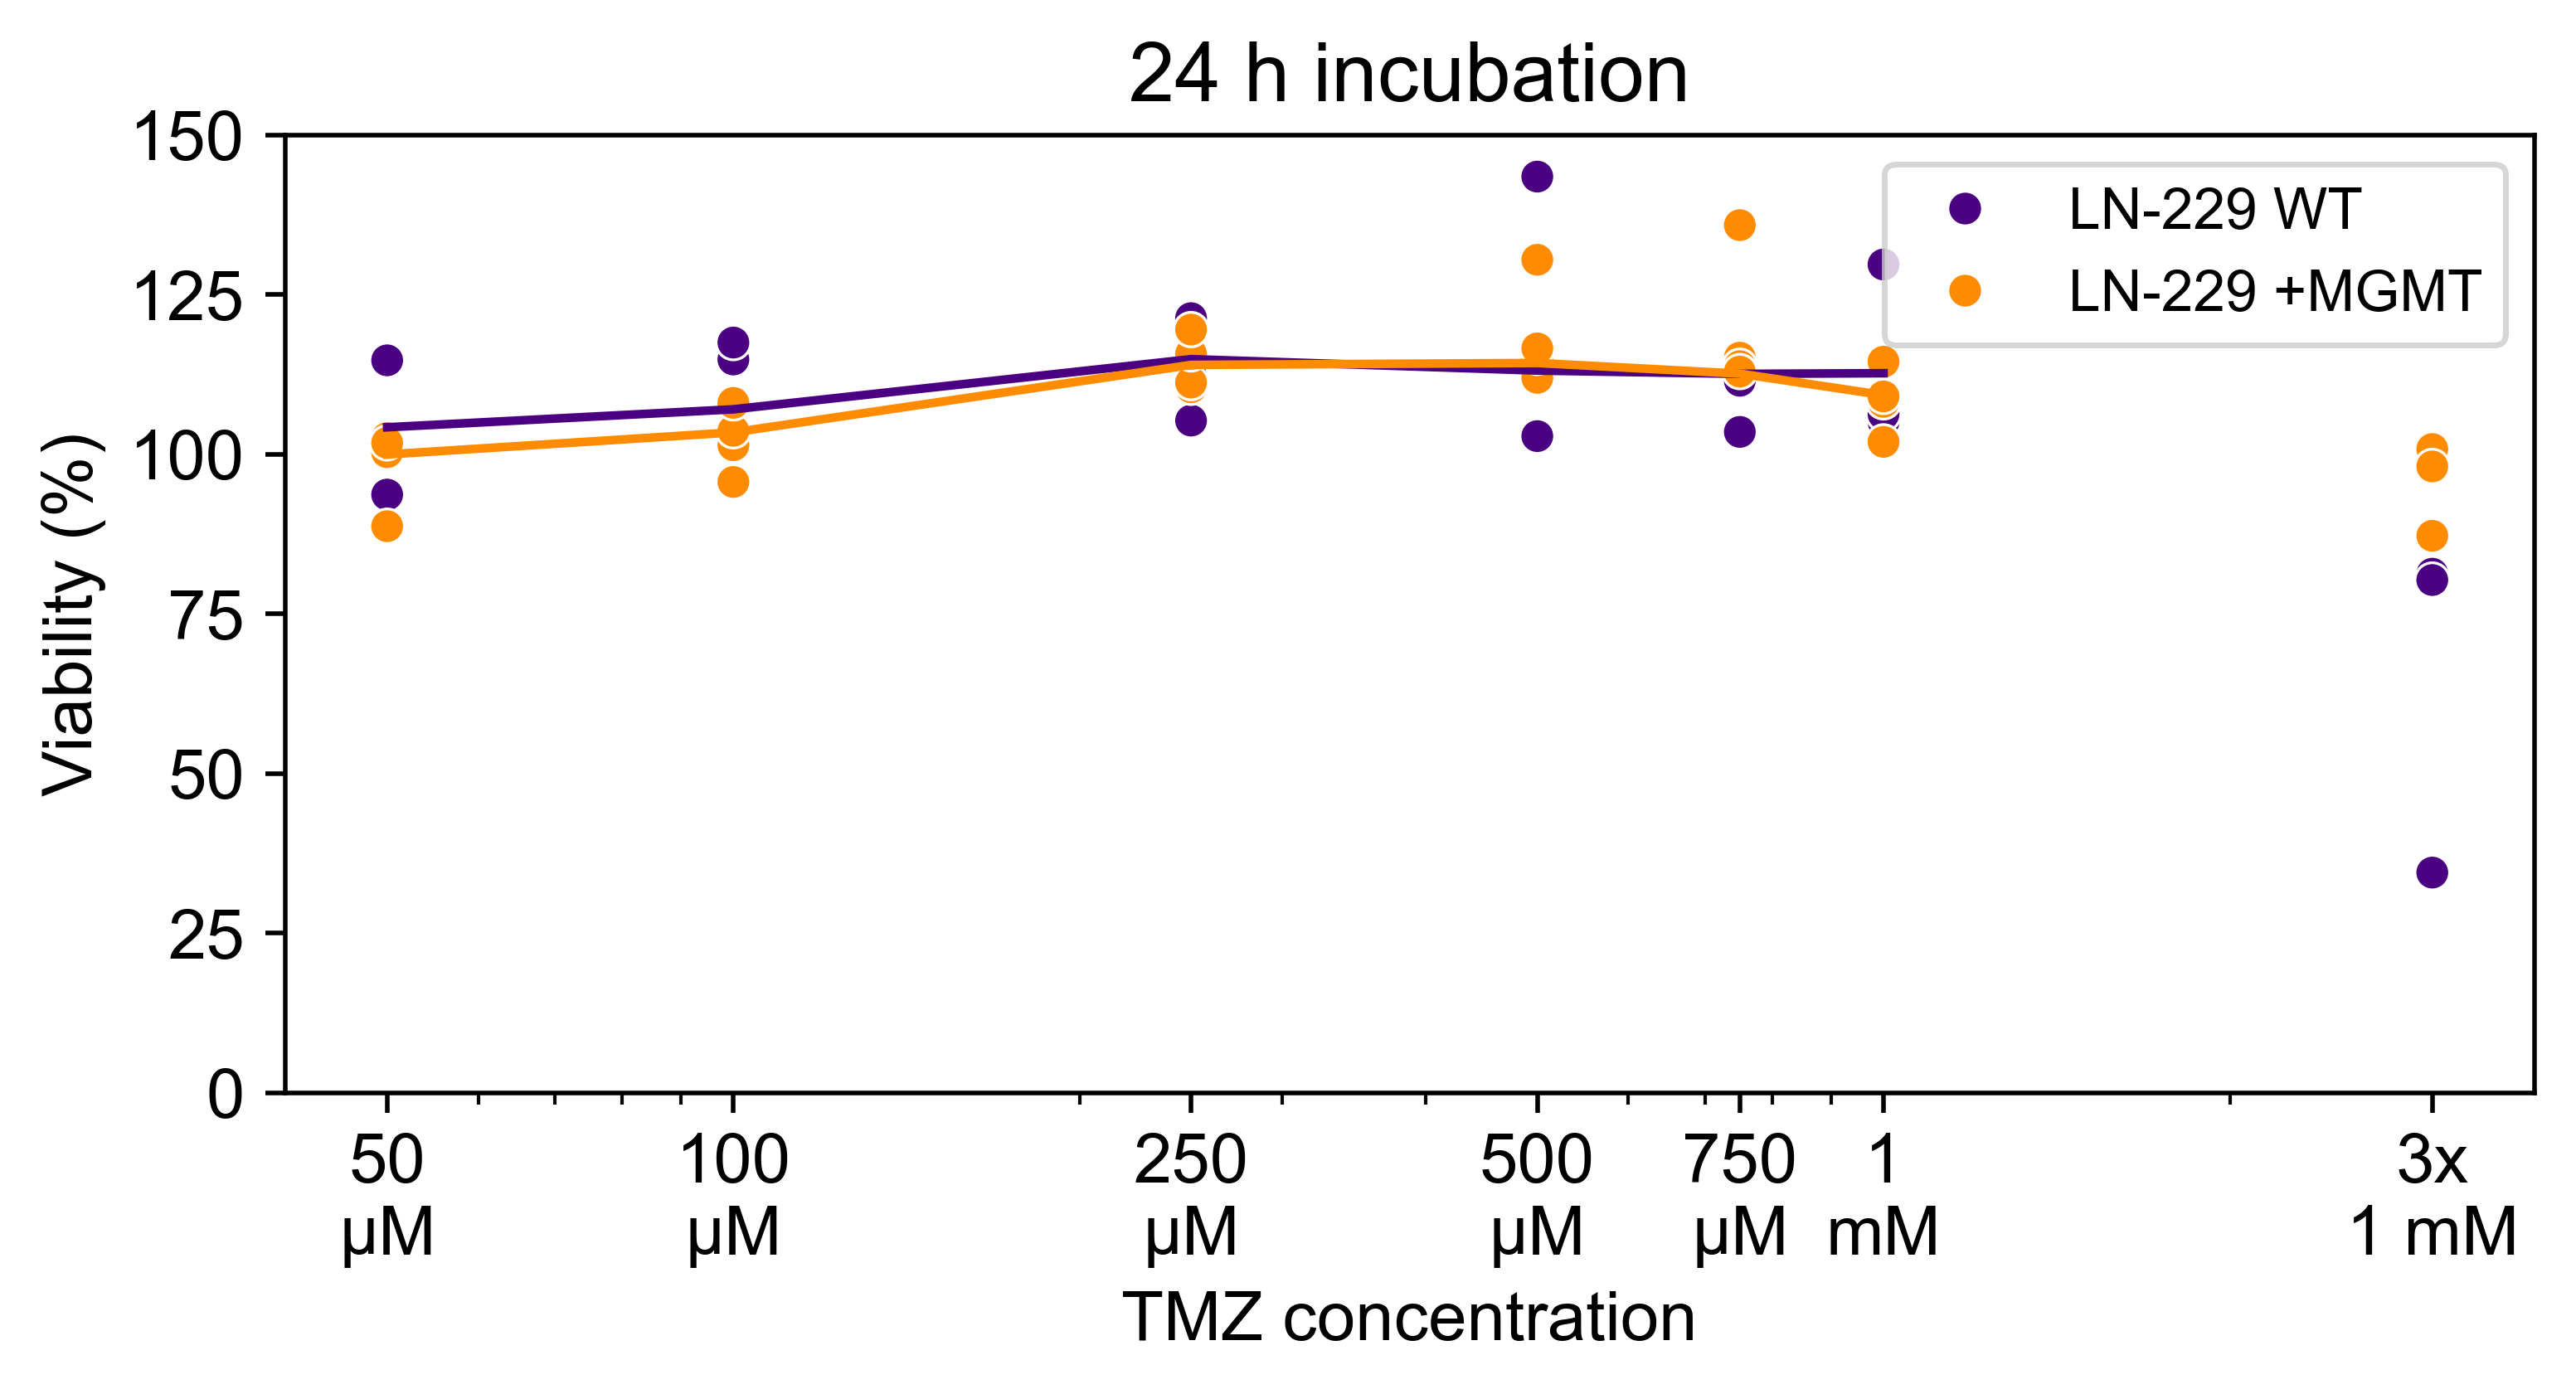

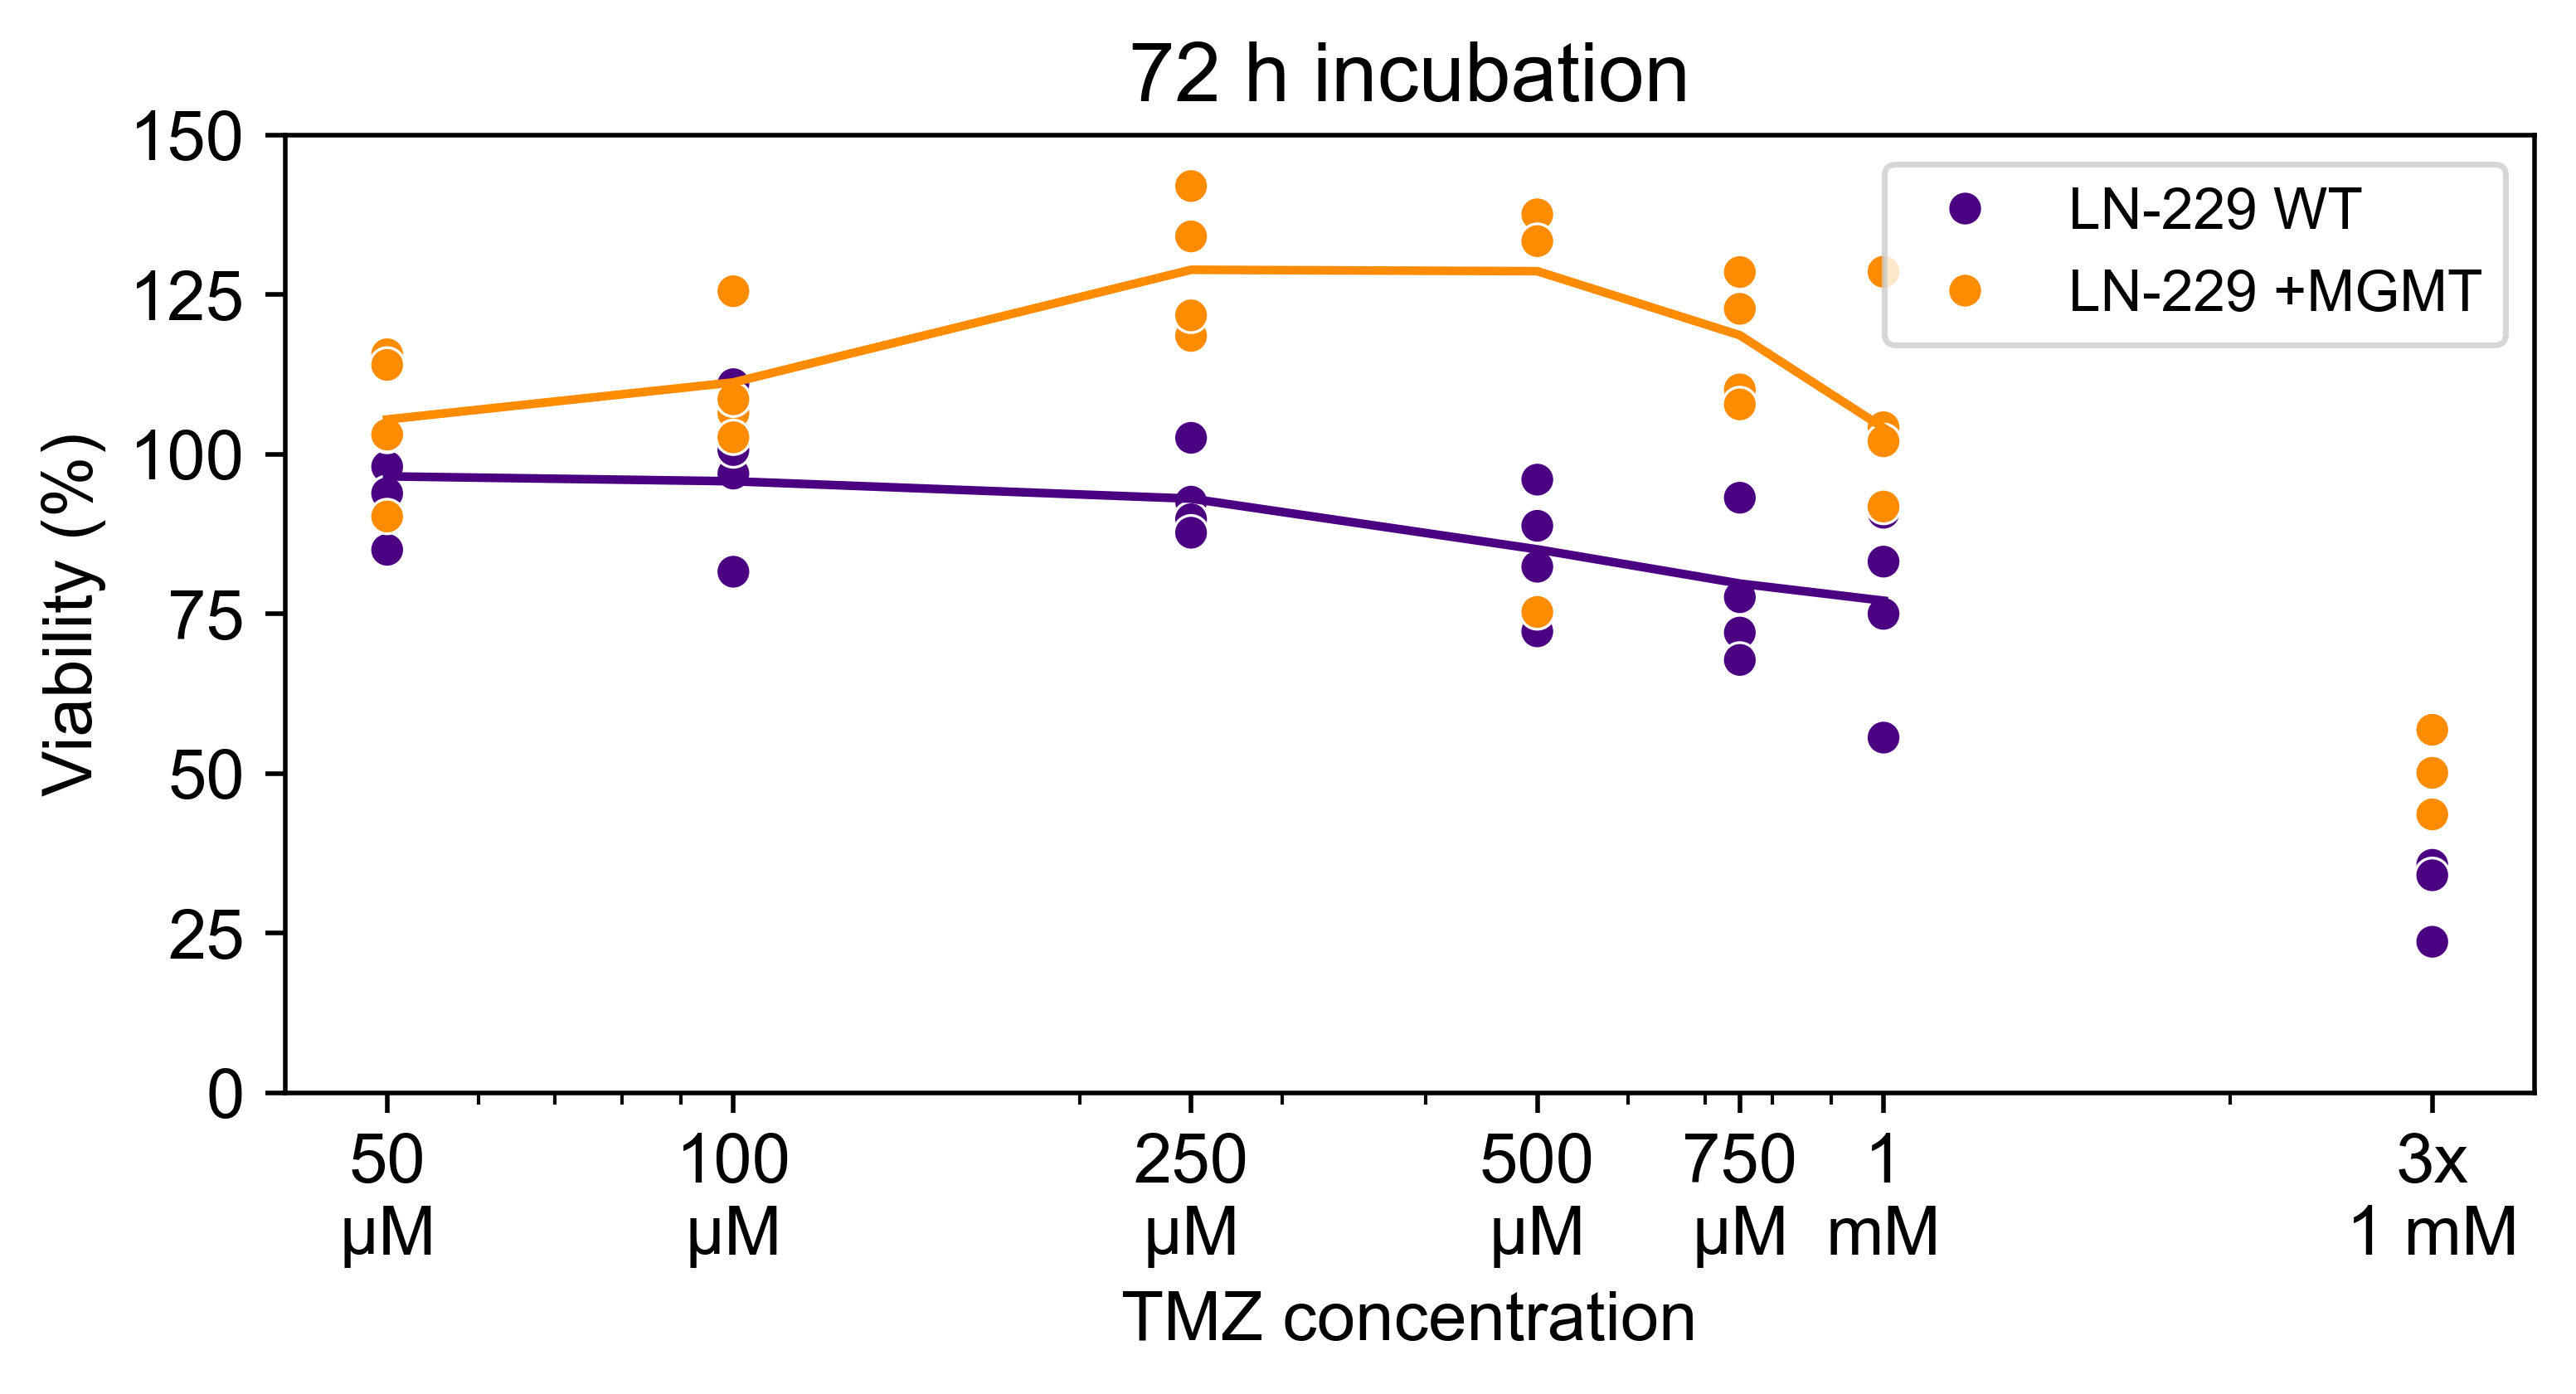

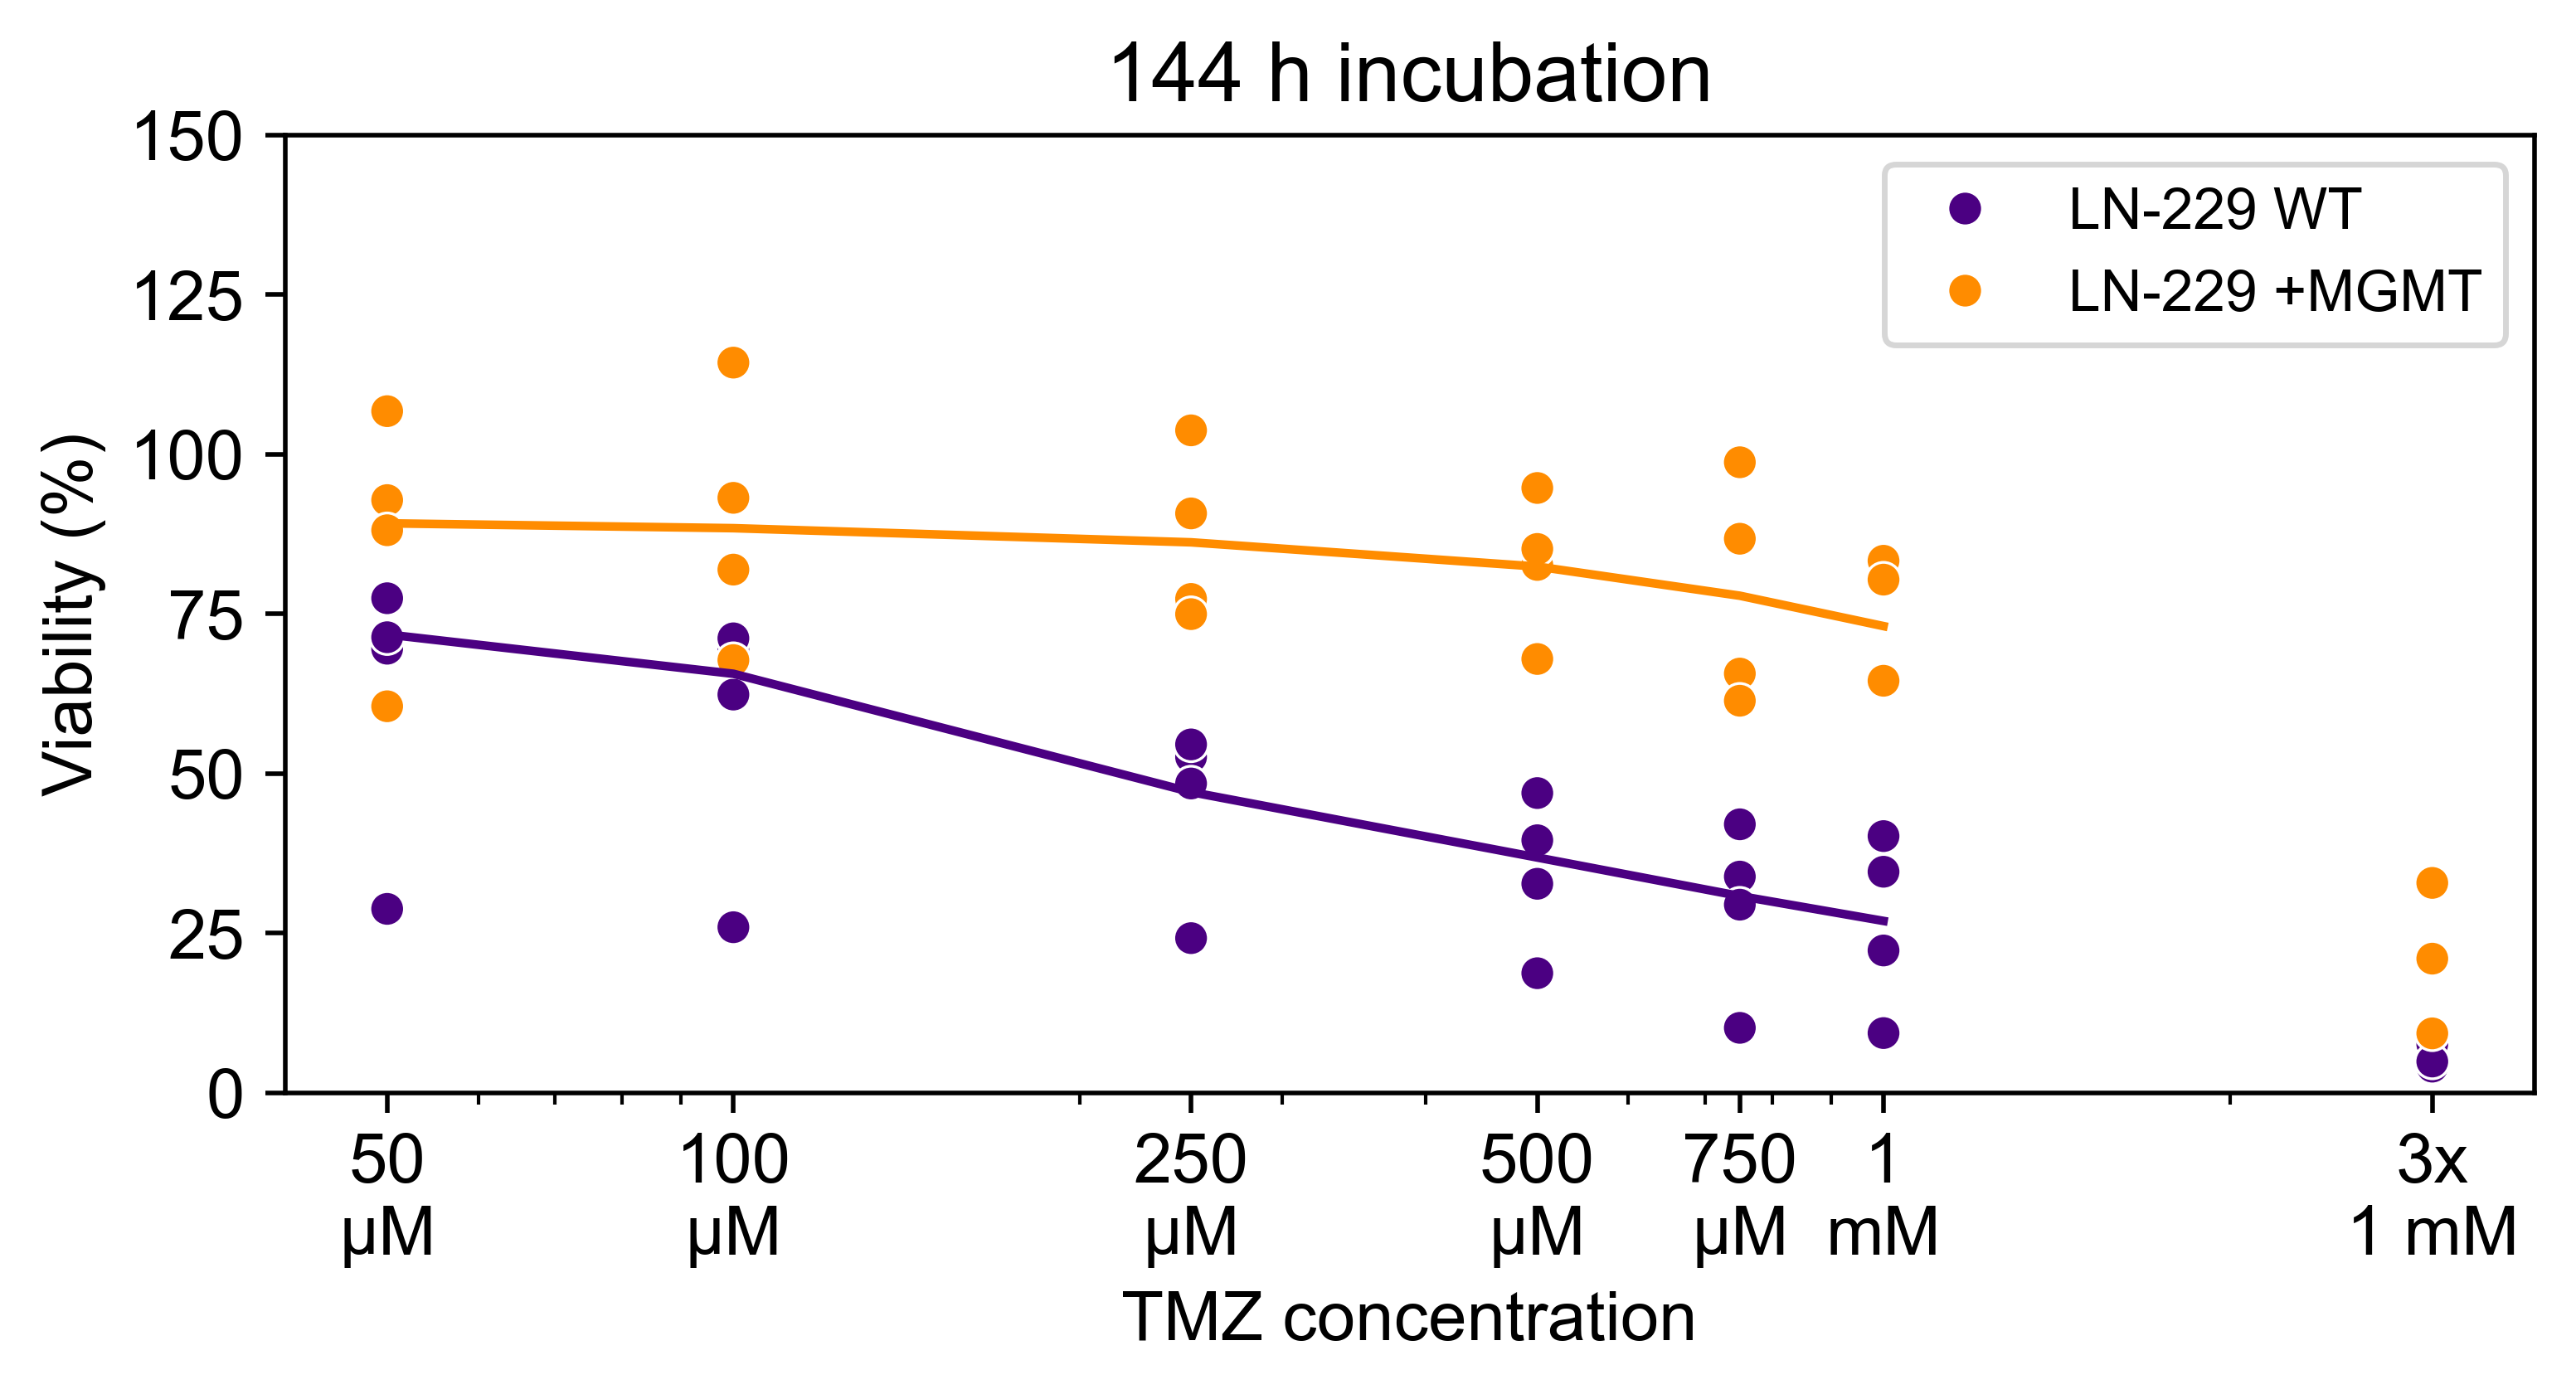

In [6]:
incubations = viability['incubation'].unique()

# Seed for consistency
np.random.seed(1)

for inc in incubations:
    

    scatter = viability[viability['incubation'] == inc].copy()
    scatter = scatter[scatter['TMZ_conc'] != 'untreated']
    scatter.TMZ_conc = pd.to_numeric(scatter.TMZ_conc)
    scatterWT = scatter[scatter['cell_type'] == 'LN-229 WT']
    scatterMGMT = scatter[scatter['cell_type'] == 'LN-229 +MGMT']

    fittingWT = scatterWT.copy()
    fittingWT = fittingWT[fittingWT['TMZ_conc'] != 3000]
    fittingWT = fittingWT[fittingWT['TMZ_conc'] != 0]
    
    smoothedWT = sm.nonparametric.lowess(exog=fittingWT.TMZ_conc, endog=fittingWT.viability)
    smoothedWT_df = pd.DataFrame({'TMZ_conc':smoothedWT[:, 0], 'viability':smoothedWT[:, 1]})
    
    fittingMGMT = scatterMGMT.copy()
    fittingMGMT = fittingMGMT[fittingMGMT['TMZ_conc'] != 3000]
    fittingMGMT = fittingMGMT[fittingMGMT['TMZ_conc'] != 0]

    smoothedMGMT = sm.nonparametric.lowess(exog=fittingMGMT.TMZ_conc, endog=fittingMGMT.viability)
    smoothedMGMT_df = pd.DataFrame({'TMZ_conc':smoothedMGMT[:, 0], 'viability':smoothedMGMT[:, 1]})


    fig, ax = plt.subplots(figsize=(7,3), dpi=500)
    sns.scatterplot(data=scatter, x= 'TMZ_conc', y='viability', hue='cell_type',
                    palette=['indigo','darkorange'], ax=ax)
    sns.lineplot(data=smoothedWT_df, x= 'TMZ_conc', y='viability', color='indigo', ax=ax)
    sns.lineplot(data=smoothedMGMT_df, x= 'TMZ_conc', y='viability', color='darkorange', ax=ax)
    
    
    ax.set_xlabel('TMZ concentration')
    ax.set_xscale('log')
    
    xlim = ax.get_xlim()
    ax.set_xticks(scatter['TMZ_conc'].unique())
    ax.set_xlim(xlim)
    
    ax.set_xticklabels([   0,   '50\nμM',  '100\nμM',  '250\nμM',  '500\nμM',  '750\nμM', '1\nmM', '3x\n1 mM'])
        
    def percent(y, pos):
        return f'{int(y*100)}'
    ax.yaxis.set_major_formatter(percent)
    ax.set_ylabel('Viability (%)')
    ax.set_ylim(0,1.5)
    
    ax.legend(fontsize='small')
    ax.set_title(f"{inc} h incubation")
    
    fig.savefig(graph_path + f"LN229_viability_{inc}h.png", bbox_inches='tight')

In [7]:
pip list

Package                              Version
------------------------------------ ---------------------
absl-py                              2.1.0
addict                               2.4.0
aiofiles                             22.1.0
aiohttp                              3.9.5
aiosignal                            1.3.1
aiosqlite                            0.20.0
alembic                              1.13.1
annotated-types                      0.7.0
anyio                                4.4.0
appdirs                              1.4.4
argon2-cffi                          23.1.0
argon2-cffi-bindings                 21.2.0
argparse-dataclass                   2.0.0
arrow                                1.3.0
asttokens                            2.4.1
astunparse                           1.6.3
async-lru                            2.0.4
attrs                                23.2.0
Babel                                2.15.0
beautifulsoup4                       4.12.3
biopython                   


[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
